# Lab 3: Learning in CNNs

### Neural Networks and Deep Learning PhD course 2019
### Huanyu Li (huali50)

## Convolution

Convolution is a way to compute the response of a kernel that is applied to a feature map, or more in general, to a signal. In order to understand the algorithmic aspects and conceptual pitfalls of convolution, we will first look into simple one-dimensional examples.  
Linear convolution of a discrete kernel $h$ and a signal $f$ is defined by the infinite sum
$$ g(x) = (h*f)(x) = \sum_{\lambda=-\infty}^\infty h(x-\lambda)f(\lambda)\enspace.$$
When $h$ and $f$ are of finite length, there are several options. To understand these, we will look at those for the case of the example  
$$ f = \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$$  

$$ h = \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$$  

The different options originate from different interpretations of the unknown values outside the range of $f$ and $h$:
*  ´'full'´: all unknown values are assumed as zero. The convolution is computed for all non-zero coefficients of $g$.
*  ´'valid'´: all unknown values of $f$ are assumed as undefined. The convolution is computed for all shifts of $h$ such that the support of $h$ lies entirely within the support of $f$.
*  ´'same'´: same as ´'full'´, but the result $g$ is restricted to of the same size as $f$. The origin (bold) is supposed not to move.  

---

**Task 1:** Try different options `'full'`/`'valid'`/`'same'` by using the function `scipy.signal.convolve` for the example above.

---

In [1]:
from scipy import signal
import numpy as np

In [2]:
def full_convolve(f, h):
    return signal.convolve(f, h, mode='full')

def valid_convolve(f, h):
    return signal.convolve(f, h, mode='valid')

def same_convolve(f, h):
    return signal.convolve(f, h, mode='same', method = 'direct')

In [3]:
f = [1, -1, -2, 0, -1, 1, 2, -1]
h = [1, 2, -2]
f = np.array(f)
h = np.array(h)
print(full_convolve(f,h))
print(valid_convolve(f,h))
print(same_convolve(f,h))

[ 1  1 -6 -2  3 -1  6  1 -6  2]
[-6 -2  3 -1  6  1]
[ 1 -6 -2  3 -1  6  1 -6]


---

**Task 2:** If $N$ is the number of coefficients in $f$ and $M$ is the number of coefficients in $h$, what is the number of coefficients in $g$ in the case `'full'`/`'valid'`/`'same'`?

---

**Answer 2:** 

##### If Step is 1 and size of kernel is odd.
##### Full: $N$ + $M$  - 1
##### Valid: $N$ - $M$ + 1
##### Same: $N$

## Image examples (2D)
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [4]:
from matplotlib import pyplot as plt

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

---

**Task 3:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      1 & 1 \\
      \hline
      1 & 1 \\
      \hline
    \end{array}$. Visualize the kernel.

---

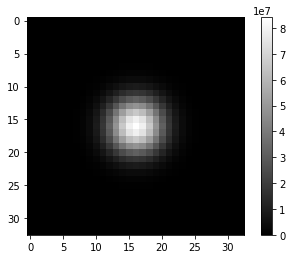

Image size: (33, 33)


In [5]:
def generate_kernel(kernel):
    for i in range(5):
        kernel = signal.convolve2d(kernel, kernel, boundary='fill', mode='full')
    return kernel
h = np.array([[ 1, 1],[1, 1]])
h = h / h.sum(axis = 0, keepdims = True)
cascad_kernel = generate_kernel(h)
visualize(cascad_kernel)

---

**Task 4:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), sum its RGB-channels, normalized it to the range [0,1], and convolve it with $h$ from task 3 under the options `'valid'` and `'same'`. What differences do you observe regarding the size of the output?

---

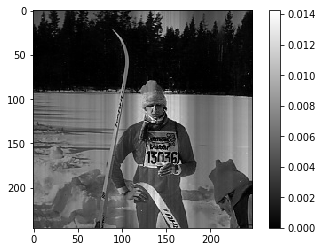

Image size: (246, 248)


In [6]:
def load_img(img_file):
    img = plt.imread(img_file)
    normalized_img = img.sum(axis=2)
    normalized_img = normalized_img / normalized_img.sum(axis=0, keepdims=True)
    return normalized_img
img = load_img('MR15^044.JPG')
visualize(img)

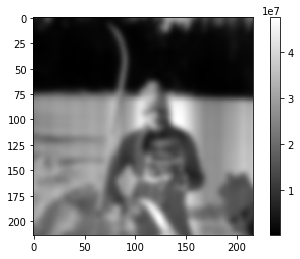

Image size: (214, 216)


In [7]:
valid_img = valid_convolve (img, cascad_kernel)
visualize(valid_img)

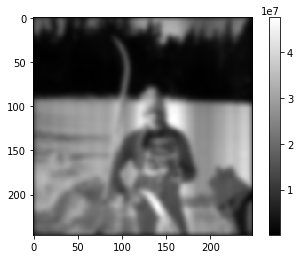

Image size: (246, 248)


In [8]:
same_img = same_convolve (img, cascad_kernel)
visualize(same_img)

**Answer 4:** 

##### In same option, the returned image has the exactly same size as the original image.

##### While in valid option, the size of the returned image is reduced in both dimensions.

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

---

**Task 5:** Visualize the input image and the second output image from task 4 (with `'same'` mode) while only keping every fifth row and column. What do you observe, in particular at the ski?
*Hint*: Use the following array slicing `img[::5,1::5]` for the convolved image to match Tensorflow in the following tasks.

---

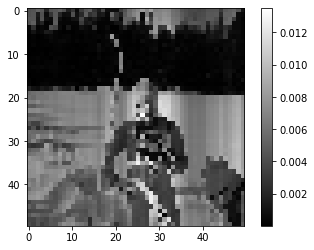

Image size: (50, 50)


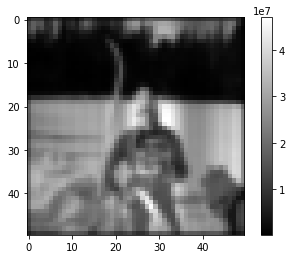

Image size: (50, 50)


In [9]:
visualize(img[::5,1::5])
visualize(same_img[::5,1::5])

**Answer 5:** 

##### The outline of the ski is difficult to identify in both two images above.

## Layers in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform **eager execution**. This is initialized as follows: 

In [10]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/frame

TensorFlow version 1.9.0
Eager execution activated!


TensorFlow allows to map from and to numpy. Also, operations are automatically casted.  

#### Keras layers are wrappers for Tensorflow and can be applied in eager mode using the `tf.keras.layers` package.  

---

**Task 6:** Perform the 1D convolution from task 1 using a convolution layer `tf.keras.layers.Conv1D` and a (trivial) `tf.keras.Sequential` model from Keras.

---

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import Sequential

class Conv1D_Single_Layer(object):
    
    def __init__(self):
        self.filters = 1
        self.kernelsize = 3
        self.kernel = [1, 2, -2]
        self.input_shape = (8, 1)
        self.model = None
    
    def construct(self, default_strides = 1):
        convolution_1d_layer = Conv1D(self.filters, self.kernelsize, strides=default_strides, padding='valid', input_shape=(8, 1), name="convolution_1d_layer",kernel_initializer = self.init_k)
        model = Sequential()
        model.add(convolution_1d_layer)
        self.model = model
    
    def init_k(self, shape, dtype=None, partition_info = None):
        return np.array([[self.kernel]]).T
    
    def set_kernel(self, kernel):
        self.kernel = kernel
        self.kernelsize = len(kernel)
    
    def predict(self, data):
        output = keras.Model(self.model.input, outputs=self.model.get_layer('convolution_1d_layer').output).predict(data)
        return output

In [12]:
f = np.array([1, -1, -2, 0, -1, 1, 2, -1])
f = np.expand_dims(f, 0)
f = np.expand_dims(f, 2)
conv1dlayer = Conv1D_Single_Layer()
conv1dlayer.construct(1)
output = conv1dlayer.predict(f)
output = np.squeeze(output, 2)
output = np.squeeze(output, 0)
print(output)

[ 3. -5.  0. -4. -3.  7.]


**Task 7:** Apply the cascaded $33\times33$ filter from task 3 to the image using a `tf.keras.layers.Conv2D` layer. Compare the results from *Scipy* in task 3 and *Tensorflow* in this task.

**Answer 7:** 

##### The results are almost the same.

In [13]:
from tensorflow.keras.layers import Conv2D
import tensorflow.keras.backend as K

class Conv2D_Layer(object):
    
    def __init__(self, filters, kernelsize, kernel):
        self.filters = filters
        self.kernelsize = kernelsize
        self.input_shape = (246, 248, 1)
        self.model = None
        self.kernel = kernel
    
    def construct(self, default_strides = 1):
        convolution_2d_layer = Conv2D(self.filters, self.kernelsize, strides=default_strides, padding='same', input_shape=self.input_shape, name="convolution_2d_layer",kernel_initializer = self.init_k)
        model = Sequential()
        model.add(convolution_2d_layer)
        self.model = model
    
    def init_k(self, shape, dtype=None, partition_info = None):
        return self.kernel
    
    def predict(self, data):
        output = keras.Model(self.model.input, outputs=self.model.get_layer('convolution_2d_layer').output).predict(data)
        return output

In [14]:
img_task7 = np.expand_dims(img, 0)
img_task7 = np.expand_dims(img_task7, 3)

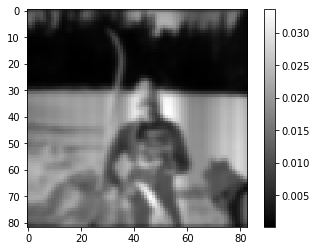

Image size: (82, 83)


In [15]:
kernel = np.expand_dims(cascad_kernel, 2)
kernel = np.expand_dims(kernel, 3)
conv2dlayer = Conv2D_Layer(1,33,kernel)
conv2dlayer.construct(3)
output_task7 = conv2dlayer.predict(img_task7)
output_task7 = np.squeeze(output_task7, 3)
output_task7 = np.squeeze(output_task7, 0)
output_task7 = output_task7 / output_task7.sum(axis=0, keepdims=True)
visualize(output_task7)

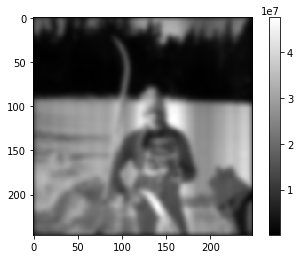

Image size: (246, 248)


In [16]:
visualize(same_convolve(img, cascad_kernel))

---

**Task 8:** Repeat the previous task with stride 5. Compare with the result from task 5.

---

**Answer 8:** 

##### The results are almost the same.

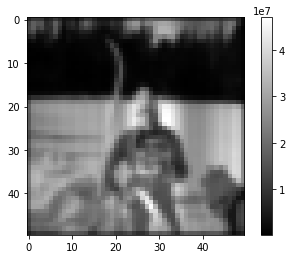

Image size: (50, 50)


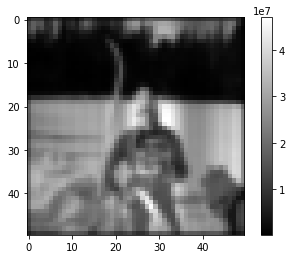

Image size: (50, 50)


In [17]:
conv2dlayer = Conv2D_Layer(1,33,kernel)
conv2dlayer.construct(5)
output = conv2dlayer.predict(img_task7)
output = np.squeeze(output, 3)
output = np.squeeze(output, 0)
visualize(output)
visualize(same_img[::5,1::5])

---

**Task 9:** Repeat task 7 with stride of 5 and a $1\times1$ filter. Compare with the result from task 5.

---

**Answer 9:** 

##### The result from tensorflow is almost the same as the original image shown every fifth rows and columns from task 5.

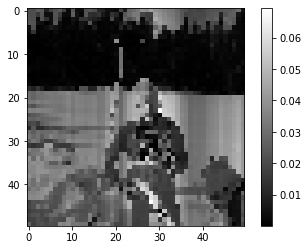

Image size: (50, 50)


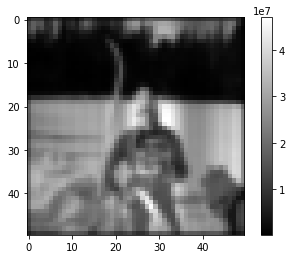

Image size: (50, 50)


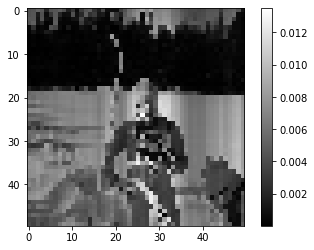

Image size: (50, 50)


In [18]:
kernel = np.expand_dims(np.array([5]), 1)
kernel = np.expand_dims(kernel, 2)
kernel = np.expand_dims(kernel, 3)
conv2dlayer = Conv2D_Layer(1,1,kernel)
conv2dlayer.construct(5)
output_task9 = conv2dlayer.predict(img_task7)
output_task9 = np.squeeze(output_task9, 3)
output_task9 = np.squeeze(output_task9, 0)
output_task9 = output_task9 / output_task9.sum(axis=0, keepdims=True)
visualize(output_task9)
visualize(same_img[::5,1::5])
visualize(img[::5,1::5])

---

**Task 10:** Generate a new $33\times33$ filter that is anti-symmetric in one axis (the one used so far was symmetric), add it as a second channel, and add its transpose to a third channel. Repeat task 7 for the new filters using both *Tensorflow* and *Scipy*. What differences do you observe between the two libraries?

*Hint*: You can generate the anti-symmetric filter by multiplying the symmetric $h$ with a matrix that has constant row elements in the range [-16,16].

---

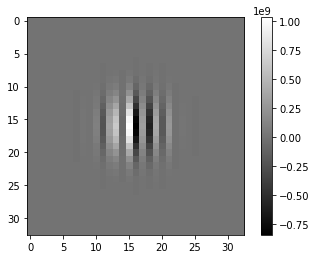

Image size: (33, 33)


In [19]:
row_constant = np.random.randint(-16,16,(1,33))
antisym_kernel = cascad_kernel * row_constant
visualize(antisym_kernel)

In [20]:
new_kernels = np.expand_dims(cascad_kernel, axis = 2)
new_kernels = np.concatenate((new_kernels, np.expand_dims(antisym_kernel, axis = 2)),axis = 2)
new_kernels = np.concatenate((new_kernels, np.expand_dims(cascad_kernel.T, axis = 2)),axis = 2)

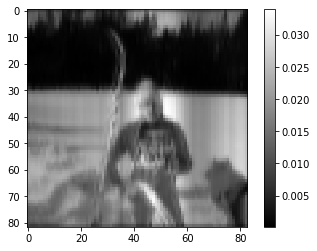

Image size: (82, 83)


In [21]:
kernel = np.expand_dims(new_kernels, 2)
conv2dlayer = Conv2D_Layer(3,33,kernel)
conv2dlayer.construct(3)
output = conv2dlayer.predict(img_task7)
output = np.squeeze(output, 0)
output = output.sum(axis=2)
normalized_output = output / output.sum(axis=0, keepdims=True)
output_task10 = np.absolute(normalized_output)
visualize(output_task10)

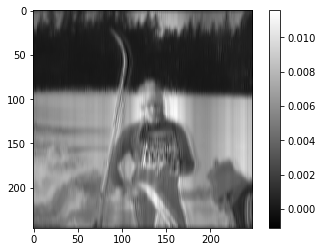

Image size: (246, 248)


In [22]:
img_original = load_img('MR15^044.JPG')
img = np.expand_dims(img_original, axis = 2)
img = np.concatenate((img, np.expand_dims(img_original, axis = 2)),axis = 2)
img = np.concatenate((img, np.expand_dims(img_original, axis = 2)),axis = 2)
output = same_convolve(img, new_kernels)
output = output.sum(axis=2)
normalized_output = output / output.sum(axis=0, keepdims=True)
visualize(normalized_output)

**Answer 10:** 

##### The results from Tensorflow and Scipy are very much different. I think the reason is because convolution functions in Scipy will reverse the kernel first before calculation. I also observe it when I compared the result from task 1 with the expected result of convolving f and h. The result from task 6 using Tensorflow is same as the expected result.

## Training layers
Now, we want the network to learn the convolution filter given the input and the convolved output.

**Task 11:** Take the input and the convolved output from task 7 and put them in tensors `batch` and `label` respectively. 

*Hint*: Check the documentation of `tf.keras.layers.Conv2D` to get the proper shape for the input and the output tensors.


In [23]:
batch = img_task7.astype(np.float32)
label = np.expand_dims(output_task7, 2)
label = np.expand_dims(label, 0).astype(np.float32)

**Task 12:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

---

In [24]:
loss_fn = tf.keras.losses.mean_absolute_error

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  

**Task 13:** Train the model from task 7 (but without assigning the weights) using the tensors from task 11, the loss from task 12, and `GradientDescentOptimizer()`. 

During training, print the loss every 100 steps and visualize the learned kernel after training.  

*Hint*: add a `kernel_constraint` to be non-negative for the convolution layer.

---

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM). 

---

In [25]:
from tensorflow.keras.layers import Conv2D, Input
import tensorflow.keras.backend as K
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import he_normal, Ones, Zeros

class Conv2D_Layer_Variant(Conv2D_Layer):
    
    def __init__(self, filters, kernelsize, kernel):
        super().__init__(filters, kernelsize, kernel)
    
    def construct(self, default_strides = 1):
        convolution_2d_layer = Conv2D(self.filters, self.kernelsize, strides=default_strides, padding='same', 
                            input_shape=self.input_shape, name="convolution_2d_layer", kernel_constraint=NonNeg(), 
                            bias_constraint=NonNeg(), kernel_regularizer=regularizers.l1(0.01), kernel_initializer=Ones())
        model = keras.Sequential()
        model.add(convolution_2d_layer)
        self.model = model

In [26]:
def train_step(net, batch, label):
    with tf.GradientTape() as tape:
        prediction = net.model(tf.convert_to_tensor(batch), training=True)
        loss  = loss_fn(label, prediction)
    grads = tape.gradient(loss, net.model.trainable_variables)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
    optimizer.apply_gradients(zip(grads, net.model.trainable_variables))
    return loss, prediction

def train(net, batch, label, epochs):
    for epoch in range(epochs):
        loss_epoch, prediction_epoch = train_step(net ,batch, label)
        if epoch % 100 is 0:
            a = np.sum(loss_epoch.numpy()) /(82*83)
            print ('Epoch {} finished and the loss is {}'.format(epoch, a))
    visualize(tf.reshape(net.model.trainable_variables[0], [33, 33]).numpy())

Epoch 0 finished and the loss is 4.099896059083896
Epoch 100 finished and the loss is 3.0420647911769025
Epoch 200 finished and the loss is 1.9842335232699089
Epoch 300 finished and the loss is 0.9264022553629151
Epoch 400 finished and the loss is 0.006268801424316263
Epoch 500 finished and the loss is 0.004342452168920059
Epoch 600 finished and the loss is 0.0047150980960331415
Epoch 700 finished and the loss is 0.004830991804967584
Epoch 800 finished and the loss is 0.0048961532911131955
Epoch 900 finished and the loss is 0.004933130520426313


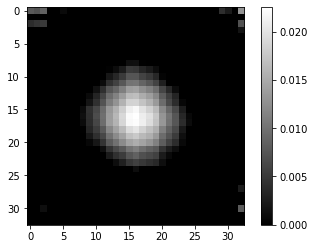

Image size: (33, 33)


In [27]:
kernel = np.expand_dims(cascad_kernel, 2)
kernel = np.expand_dims(kernel, 3)
conv2dlayer = Conv2D_Layer_Variant(1,33,kernel)
conv2dlayer.construct(3)
train(conv2dlayer, batch, label, 1000)

**Answer 13:** 

##### The above result shows that the kernel obtained after 1000 spochs is similar to the one generated in task 3.

## Training a whole network

**IMPORTANT**: The reminder of the lab will be executed in *graph* mode. So make sure to restart the kernel from `kernel` menu above.

---

So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. 

If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. However, debugging becomes a bit more difficult which is why we need an additional tool.  

*  Keras models come with a handy member variable `history` for this purpose, which we will use below.  
*  TensorFlow comes by default with `tensorboard` (which we will not use here). To use it, the code needs to be extended with named tags for all entities that are supposed to be observable. A key module is `tf.summary` with functions for various types and the 'collector' `tf.summary.merge_all()`. Tensorboard itself is then launched using `tensorboard --logdir /tmp/...` where the exact filename is specified as argument `tf.summary.FileWriter()`. In order to see graphs of the observed entities, a browser needs to be directed to `localhost:6006`.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/tensorflow/python/frame

**Task 14:** We will train on CIFAR10, which is supported by Keras. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
x_train = (x_train/255) - 0.5
x_test = (x_test/255) - 0.5
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

**Task 15:** Build the depicted LeNet5-inspired model using Keras standard components.
![title](model.png)

### Baseline
We will now train a baseline network. For displaying the performance we define a helper function:

In [3]:
def plot_model_history(model):
    plt.figure(0)
    plt.plot(model.history['acc'],'r', lw=3)
    plt.plot(model.history['val_acc'],'b', lw=3)
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['Training','Validation'])
    plt.grid(True)

**Task 16:** Train the *baseline* model for 50 epochs and a suitable batch size and display the result.

In [4]:
from tensorflow.keras.layers import Activation, Flatten, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class LeNet_Base(object):
    def __init__(self):
        self.model = None
        self.input_shape = (32, 32, 3)
        
    def train(self, trainX, trainY, testX, testY, epoch, opt = 'sgd', batchsize = 64):
        self.model = self.construct_net()
        self.model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(trainX, trainY, epochs=epoch, batch_size=batchsize, validation_data=(testX, testY), verbose=0)
        return self.model, history
    
    def construct_net(self):
        model = tf.keras.Sequential()
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=self.input_shape))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(10, activation = 'softmax'))
        return model
    
    def evaluate(self, testX, testY):
        _, acc = self.model.evaluate(testX, testY, verbose=0)
        return acc

0.8175


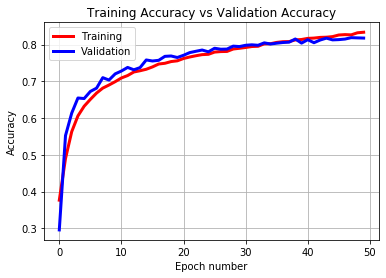

In [5]:
lenet = LeNet_Base()
opt = SGD(lr=0.001, momentum=0.9)
model, history = lenet.train(x_train, y_train, x_test, y_test, 50, opt, 128)
plot_model_history(history)
print(lenet.evaluate(x_test, y_test))

### Baseline + Decaying Learning Rate
In most papers, the learning rate is successively reduced in order to boost the final performance, e.g. divided by two after 30 and 40 epochs.  

**Task 17:** Define a suitable callback function and train the previous model with decaying learning rate. Plot the result and compare it to the baseline.

In [6]:
class LeNet_DecayLR(LeNet_Base):
    
    def __init__(self):
        super().__init__()
        
    def train(self, trainX, trainY, testX, testY, epoch, opt = 'sgd', batchsize = 64):
        self.model = self.construct_net()
        #opt = SGD(lr=1e-3, momentum=0.9)
        self.model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        lr_decay = self.step_decay_lr(initial_lr=1e-3, decay_factor=0.5, step_size=2)
        history = self.model.fit(trainX, trainY, epochs=epoch, batch_size=batchsize, validation_data=(testX, testY), verbose=0, callbacks=[lr_decay])
        return self.model, history
    
    def step_decay_lr(self, initial_lr=1e-3, decay_factor=0.5, step_size=2):
        def schedule(epoch):
            return initial_lr * (decay_factor * np.floor(epoch/step_size))
        return LearningRateScheduler(schedule)

0.8428


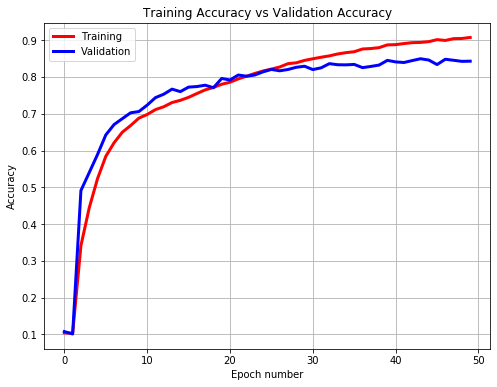

In [7]:
lenet_decaylr = LeNet_DecayLR()
opt = SGD(lr=0.001, momentum=0.9)
model, history = lenet_decaylr.train(x_train, y_train, x_test, y_test, 50, opt, 128)
plot_model_history(history)
print(lenet_decaylr.evaluate(x_test, y_test))

### Weight regularization + Decaying Learning rate

**Task 18:** Add weight regularization and train the model from the previous task with varying decay rate.

In [8]:
from keras.regularizers import l2

class LeNet_RegularW(LeNet_DecayLR):
    
    def __init__(self):
        super().__init__()
         
    def construct_net(self):
        model = tf.keras.Sequential()
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=self.input_shape))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('elu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(10, activation = 'softmax', kernel_regularizer=l2(0.0001)))
        return model

Using TensorFlow backend.


0.8477


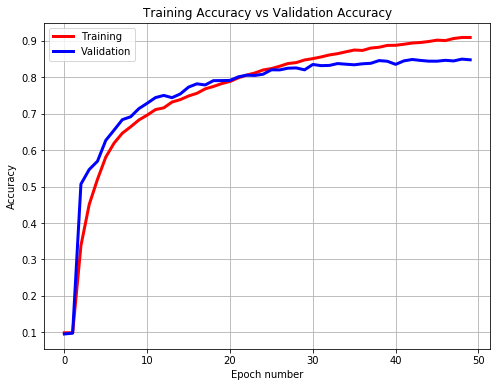

In [9]:
lenet_regularw = LeNet_RegularW()
opt = SGD(lr=0.001, momentum=0.9)
model, history = lenet_regularw.train(x_train, y_train, x_test, y_test, 50, opt, 128)
plot_model_history(history)
print(lenet_regularw.evaluate(x_test, y_test))

### Weight Regularization + Data Augmentation + Decaying learning rate
**Task 19:** Use `ImageDataGenerator`to perform additional augmentation with rotation. Adjust the number of epochs and the learning rate schedule if needed. What do you observe?

In [10]:
from keras.preprocessing.image import ImageDataGenerator
class LeNet_Augment(LeNet_RegularW):
    def __init__(self):
        super().__init__()
        
    def train(self, trainX, trainY, testX, testY, epoch, opt = 'sgd', batchsize = 64):
        self.model = self.construct_net()
        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
        it_train = datagen.flow(trainX, trainY, batch_size=batchsize)
        steps = int(trainX.shape[0] / batchsize)
        self.model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        lr_decay= self.step_decay_lr(initial_lr=1e-3, decay_factor=0.5, step_size=2)
        history = self.model.fit_generator(it_train, steps_per_epoch=steps, epochs=epoch, validation_data=(testX, testY), verbose=0, callbacks=[lr_decay])
        return self.model, history

0.8861


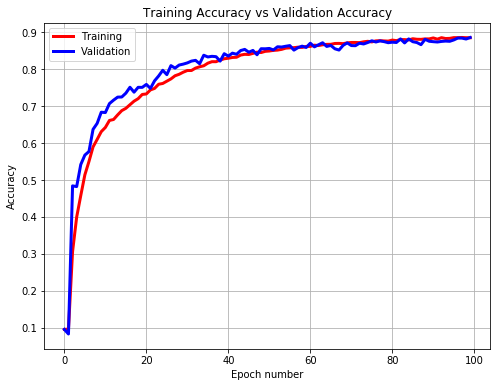

In [11]:
lenet_aug = LeNet_Augment()
opt = SGD(lr=0.001, momentum=0.9)
model, history = lenet_aug.train(x_train, y_train, x_test, y_test, 100, opt, 128)
plot_model_history(history)
print(lenet_aug.evaluate(x_test, y_test))

In [12]:
# The structure of the model which is same as the given model.
print(lenet.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
__________

In [13]:
#The accuracy of previous four experiments.
print(lenet.evaluate(x_test, y_test))
print(lenet_decaylr.evaluate(x_test, y_test))
print(lenet_regularw.evaluate(x_test, y_test))
print(lenet_aug.evaluate(x_test, y_test))

0.8175
0.8428
0.8477
0.8861


**Reflection:** 

##### The previous results show that decaying learning rate and augmenting the data bring much improvement compared with the baseline. However I did not see regularization increases the accuracy too much, sometimes, the result is very close to the one combining basline and decaying learning rate when I add regularization on both convolution layers and the dense layer. Finally, by just adding regularization on the dense layer, the accuracy is slightly improved. 
##### The experiment below shows that Adam increases the accuracy much compared with SGD.
##### Another observation is, in the experiment with data augmentation, the accuracy on validation data is close to that on training data. This is a good explanation that data augmentation makes the model more generalized and avoids overfitting. 

In [14]:
from tensorflow.keras.optimizers import Adam
lenet = LeNet_Base()
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model, history = lenet.train(x_train, y_train, x_test, y_test, 50, opt, 128)

0.8589


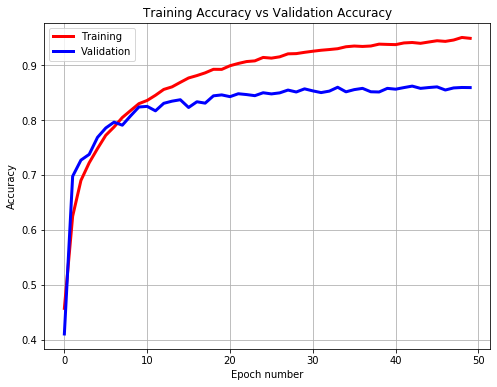

In [15]:
plot_model_history(history)
print(lenet.evaluate(x_test, y_test))